# Shared Response Modeling

Which aspects of brain responses are reliable across different participants when performing the same task, for example, while watching a movie? In previous notebooks, inter-subject correlation and inter-subject functional correlation revealed similarity in patterns of brain activity across participants. However, these methods relied on alignment across participants, such that the same voxels in different participants need to have the same function. Is there a way we can exploit the fact that stimuli evoke similar patterns of activity across participants, without assuming anatomical alignment?

Yes we can! We can use the shared response to a movie to find a lower-dimensional shared space that retains features of the data that are common across participants. The shared response model (SRM) aims to learn this "shared feature space" and then defines how to map individual participant data into it ([Chen et al., 2015](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model)). SRM can be used as a functional alignment technique: once fit, other data from the same participants can be transformed into the shared space with these mappings, to be used as input for other analyses.

In SRM, the brain data for each participant $i$ are represented as an $n$ voxel by $t$ time matrix $X_i$. A pre-specified number of features are used to learn a $k$ feature by $t$ time shared space $S$ and a participant-specific $n$ voxel by $k$ feature matrix $W_i$. This weight matrix, reflecting the loading of voxels onto features, is randomly initialized then fit over iterations to minimize the error in explaining participant data. At the same time, the time course of the features in the shared space is learned. This whole process can be summarized graphically as follows (from [Cohen et al., 2017](https://www.nature.com/articles/nn.4499)):

![image](https://media.springernature.com/lw685/springer-static/image/art%3A10.1038%2Fnn.4499/MediaObjects/41593_2017_Article_BFnn4499_Fig4_HTML.jpg?as=webp)

SRM requires that each participant is exposed to the same sequence of stimulus events. For this reason, continuous movies or stories are often used, although datasets (e.g., block-design localizers) where the trials are in the same order across participants have also been used with SRM. If counterbalancing was used between participants, it is technically possible to still perform SRM by rearranging the data, although mileage may vary. For best results, the epochs that are counterbalanced ought to be long (e.g., >30s). It is also important to note that SRM needs a lot of training data -- about 400 TRs or more for stable performance.

## Goal of this script
    1. Learn how to fit SRM.  
    2. Use SRM to match a movie time segment.  
    3. Use SRM to classify other datasets.  


## Table of Contents
[1. Setup](#setup)  
[2. SRM training](#srm_training)  
[3. SRM testing](#srm_testing)  
[4. Signal reconstruction](#srm_reconstruction)  
[5. Time-segment matching](#time_seg)  
[6. Image class prediction](#image_pred)

#### Exercises
>[1](#ex1)   [2](#ex2)  [3](#ex3)  [4](#ex4)  [5](#ex5)  [6](#ex6)  [7](#ex7)  [8](#ex8)   [9](#ex9)  [10](#ex10)  [11](#ex11)  [12](#ex12)   
>[Novel contribution](#novel)  

In [5]:
# Import utils
import sys
sys.path.insert(0, '..')
from utils import * 

# Import this name for ease
from brainiak.funcalign.srm import SRM
from brainiak.fcma.util import compute_correlation

## 1. Setup <a id="setup"></a>

### Dataset description<a id="data_description"></a>

We will be using the Raiders dataset ([Haxby et al., 2011](https://doi.org/10.1016/j.neuron.2011.08.026)). We are using a pre-processed version of the data containing voxels from ventral temporal (VT) cortex in 10 participants watching the movie "Raiders of the Lost Ark." For these same participants and voxels, the dataset also includes eight runs where participants viewed images from seven categories. Each TR was 3s long and the movie was 2203 TRs long in total. Because the data have already been pre-processed and turned into a numpy file, we don't need to load them with nibabel tools.

Below we load in the Raiders data:

In [6]:
print (f'Raiders dataset directory: {raider_data_dir}')

# Load and inspect the shape of the BOLD data
movie_data = np.load(os.path.join(raider_data_dir, 'derivatives/movie.npy'))
movie_data = movie_data.astype(np.float)

# Pull out the shape data
vox_num, nTR, num_subs = movie_data.shape  

print('Participants: ', num_subs)
print('Voxels per participant: ', vox_num)
print('TRs per participant: ', nTR)

Raiders dataset directory: /farmshare/home/classes/psych/236/data/raider
Participants:  10
Voxels per participant:  1000
TRs per participant:  2203


### Splitting data into training and test  <a id="split"></a>

We need to divide our data into training and test sets. The training data is used to train the model (i.e., to find the transformation from voxel space into feature space) and the test data is used for evaluating the model. In this case, we are going to split each participant's movie viewing data down the middle, using the first half for training and the second half for testing. 

When a dataset is continuous like this we will often use one half for training and the other half for testing in one fold, reverse the training and test sets in a second fold, and then average the results across both folds. This is not possible with all datasets though, such as when the test is run on a qualitatively different type of task.

In [7]:
# Take the first half of TRs for training.
train_data = movie_data[:, :nTR//2, :]

# and the second half of TRs for testing.
test_data = movie_data[:, nTR//2:, :]

# Reformat the dimensions. 
train_data = np.moveaxis(train_data, [2, 0, 1], [0, 1, 2])
test_data = np.moveaxis(test_data, [2, 0, 1], [0, 1, 2])

We now normalize the data. This is done separately for training and testing data, to avoid peeking and double-dipping that could occur if the test data impacted the training normalization (e.g., mean and variance). Re-read these considerations in the Classification notebook if you need a reminder

In [8]:
# Iterate through the participants
for sub in range(num_subs):    
    
    # Normalize training data
    train_data[sub] = stats.zscore(train_data[sub], axis=1, ddof=1)
    train_data[sub] = np.nan_to_num(train_data[sub])
    
    # Normalize test data
    test_data[sub] = stats.zscore(test_data[sub], axis=1, ddof=1)
    test_data[sub] = np.nan_to_num(test_data[sub])


**Exercise 1:**<a id="ex1"></a> The organization of training and test data is essential for compatibility with SRM. What do the dimensions of the data correspond to?

**A:**

## 2. SRM training <a id="srm_training"></a>

We are now ready to fit the data with SRM. To use SRM, we first create an object in BrainIAK with a specified number of features and iterations. We then fit this to our data.

We have used objects before, such as when making an SVM model or making a Searchlight. Importantly, the SRM object has 'change-in-place' properties. This means that when you fit the data with this SRM object, that object is now changed to contain the results of fitting. If you wanted to fit new data, you would need to create a new object.

Ideally, the number of features should be chosen using cross-validation. We will follow the lead of [Chen et al. (2015)](https://papers.nips.cc/paper/5855-a-reduced-dimension-fmri-shared-response-model) for now and use 50 features. Typically, 20 iterations should be enough for SRM to converge.

In [9]:
features = 50  # How many features will you fit?
n_iter = 20  # How many iterations of fitting will you perform?

# Create the SRM object.
srm = SRM(n_iter=n_iter, features=features)

# Fit SRM with training data.
print('Fitting SRM, may take a minute ...')
srm.fit(train_data)

print('SRM has been fit')

Fitting SRM, may take a minute ...
SRM has been fit


To better understand the SRM model that was just created, we can explore the fitted object: 

In [6]:
srm?

We can also explore the newly fitted data, or the "shared response." Let's view the time course of the shared response captured by each feature. Features are ordered in terms of the variance explained (much like a PCA).

SRM: Features x Time-points  (50, 1101)


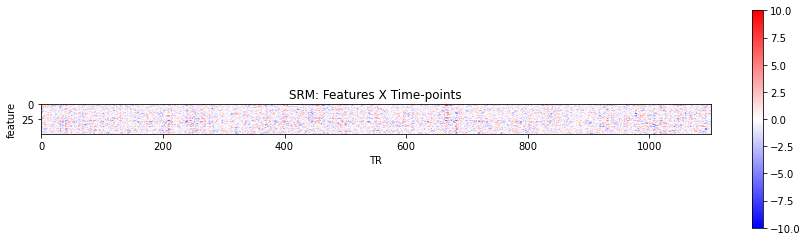

In [7]:
# Plot the shared response
print('SRM: Features x Time-points ', srm.s_.shape) 
plt.figure(figsize=(15, 4))
plt.title('SRM: Features X Time-points')
plt.xlabel('TR')
plt.ylabel('feature')
plt.imshow(srm.s_, cmap='bwr',vmin=-10,vmax=10) 
plt.colorbar();

Let's zoom in and look at the first feature, i.e., the one that explains the most variance:

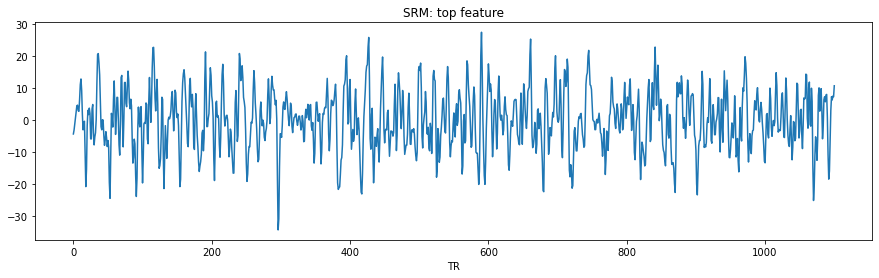

In [8]:
plt.figure(figsize=(15, 4))
plt.title('SRM: top feature')
plt.xlabel('TR')
plt.plot(srm.s_[0, :]);

By definition, this feature of brain activity is found consistently across participants. However, it is unclear where in the brain this feature is expressed. It is also unclear what stimulus information this feature represents. 

When there are spikes in the time course, such as around time point 300, something happened in the movie that is imporant to this feature. We could go back to the movie and examine what happened on screen at this time point, which would help better interpret the feature. For instance, we could go through the movie and code all of the times that Indiana Jones is in the scene and see if these spikes correspond to his presence. In reality, this feature is likely to code something much more abstract and complex than a specific person.

### Similarity of timepoints <a id="srm_timepoints"></a>

We can now use this shared response to estimate how similar each timepoint is to one another. In other words, we treat each time point as a pattern of activity across the features (vector of length 50) and we correlate the pattern for each time point with the pattern for all other time points. This is analogous to the spatial ISC analysis from ISC notebook. To do this, we calculate the correlation between all time points in this $k$-dimensional space. Here, we are visualizing just the first 200 timepoints, so the patterns are more highlighted. Yellow means that the time points are closer together or more similar. 

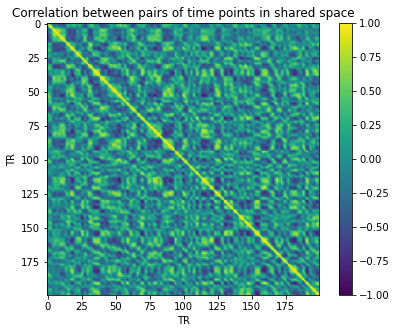

In [9]:
# Create a time by time correlation matrix, using the first 200 time points and all of the features
corr_mat = np.corrcoef(srm.s_.T[:200, :]) 

plt.figure(figsize=(7,5))
plt.title('Correlation between pairs of time points in shared space')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(corr_mat, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar();

Now do the same, but just using the first 10 features, rather than all 50

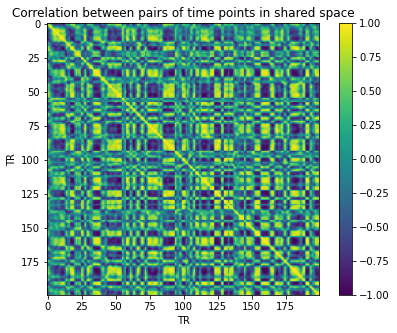

In [10]:
# Create a time by time correlation matrix, using the first 200 time points and the first 10 features
corr_mat = np.corrcoef(srm.s_.T[:200, :10]) 

plt.figure(figsize=(7,5))
plt.title('Correlation between pairs of time points in shared space')
plt.xlabel('TR')
plt.ylabel('TR')
plt.imshow(corr_mat, cmap='viridis', vmin=-1, vmax=1)
plt.colorbar();

**Exercise 2:**<a id="ex2"></a>  The second correlation matrix is more blocky, with sharp transitions. How should you interpret this blocky structure (compared to the more smooth results in the first matrix) with regard to transitions in mental/perceptual states? Hint: If you aren't sure how to approach this, refer to the slides in the RSA lecture on how to read an RSM/RDM.

**A:**

### The weight matrix <a id="srm_weights"></a>

In addition to the shared response matrix, we now also have an $n$ voxel by $k$ feature weight matrix for each participant that specifies how to map their data into the shared space. This is the key functional alignment transformation matrix. Below we visualize the weights associated with each feature for the same (anatomically-aligned) voxel in two different participants. Below, each dot represents the weight on to a feature for each participant

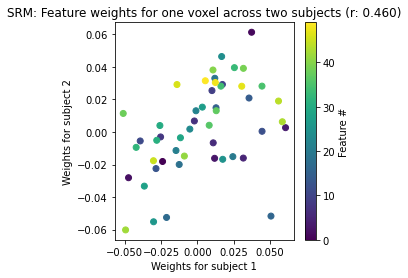

In [11]:
f,ax = plt.subplots(1,1,figsize=(4,4))

# Plot the feature weights for a voxel
plt.scatter(srm.w_[0][0,:], srm.w_[1][0,:], c=np.arange(features))
c = plt.colorbar(label='Feature #')

# Compute the correlation between weights for a feature
feature_corr = np.corrcoef(srm.w_[0][0,:], srm.w_[1][0,:].T)[0,1]

# Set the titles
ax.set_title('SRM: Feature weights for one voxel across two participants (r: %0.3f)' % feature_corr) 
ax.set_xlabel("Weights for participant 1")
ax.set_ylabel("Weights for participant 2");


If voxel $i$ in participant 1 and voxel $i$ in participant 2 have identical function, then the dots in this scatter plot should form a diagonal line, because that means for any given feature, this voxel has equal weights on the features across participants. In the plot we just showed there is slight trend of a diagonal line, this shows that the same voxel loads on the features differently across participants. This means that anatomical alignment was not sufficient to align this function. Voxels that are more correlated with one another in terms of their raw time course are more likely to have similar loading into SRM space, regardless of anatomy.

### ISC and SRM <a id="srm_alignment"></a>

After learning the shared space, we can also transform (i.e., functionally align) new data from the same participants. This produces a $k$ feature by $t$ time matrix for each participant based on what components of their brain activity are shared with other participants. The `srm.transform` method is used for this purpose.

In [12]:
# Transform the SRM data into shared space
shared_train = srm.transform(train_data)

Insofar as SRM worked, these projected feature time courses should be *more* similar across participants than the original voxel activity. We can test this with ISC: even though the shared features aren't in brain space, the are still a vector in time that we can use as input to the ISC function.

In [13]:
# Reorder the dimensions of the raw data for ISC: (TRs x Voxels x subj)
train_data_raw = np.transpose(train_data,[2,1,0])
print('voxel space data reshaped for isc:',train_data_raw.shape)

# Perform ISC on all participants, collapsing across participants.    
corr_raw = isc(train_data_raw, summary_statistic='mean')
corr_raw = np.nan_to_num(corr_raw)  

# Reorder the dimensions for shared data for ISC: (TRs x features x subj)
shared_train_reshaped = np.transpose(shared_train,[2,1,0])
print('shared space data reshaped for isc:',shared_train_reshaped.shape)

# Perform ISC on all participants, collapsing across participants        
corr_shared = isc(shared_train_reshaped, summary_statistic='mean')
corr_shared = np.nan_to_num(corr_shared)

voxel space data reshaped for isc: (1101, 1000, 10)
shared space data reshaped for isc: (1101, 50, 10)


We just ran ISC separately on the raw voxels and the SRM features. Now we want to show the distribution of these two ISC scores. Below we make a function put them on the same axes, then make the figure. Finally we perform a t test to compare them.

In [14]:
def plot_dual_histograms(y1, y2, names):
    # Plot two histograms on the same plot, using different axes. This means that if there are different counts between groups you can still show them

    # Sets up the axis and gets histogram data
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    n, bins, patches = ax1.hist([y1,y2], bins=20)
    ax1.cla() #clear the axis

    # Plots the histogram data
    width = (bins[1] - bins[0])
    bins_shifted = bins + width
    ax1.bar(bins[:-1], n[0], width, align='edge', color='b', alpha=0.5)
    ax2.bar(bins_shifted[:-1], n[1], width, align='edge', color='g', alpha=0.5)

    # Labels the plot with the appropriate colors
    ax1.set_ylabel(names[0] + " count", color='b')
    ax2.set_ylabel(names[1] + " count", color='g')
    ax1.tick_params('y', colors='b')
    ax2.tick_params('y', colors='g')
    plt.tight_layout()
    plt.show()

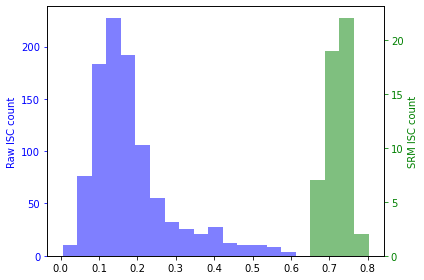

In [15]:
# Plot the correlation values on the same axes
plot_dual_histograms(corr_raw, corr_shared, ['Raw ISC', 'SRM ISC'])

In [16]:
# Perform a statistical test comparing distributions.
tstat = stats.ttest_ind(np.arctanh(corr_shared), np.arctanh(corr_raw)) # arctanh is performed to do a fisher transform, which is appropriate
print('Independent samples t test of SRM > raw ISC: t=%0.2f, p=%0.3f' % (tstat.statistic, tstat.pvalue))

Independent samples t test of SRM > raw ISC: t=39.71, p=0.000


**Exercise 3:**<a id="ex3"></a> In the above analysis you found substantially greater similarity between participants after SRM, across all the dimensions. This worked really well, with correlations between 0.6 to 0.75 for **all** the features -- which we don't normally see for fMRI data. However, there is circularity in this analysis! Explain why this is circular and what effect this is having on the test.

**A**:

## 3. SRM testing <a id="srm_testing"></a>

Above, we tested the SRM model on the data we used to train it. Instead, we should evaluate the model on some data that was never seen by SRM. We held out half of the timeseries data as test data, so we'll test our model on that data.

**Exercise 4:**<a id="ex4"></a> Transform the test data into the shared space. Make a variable called `shared_test` that is akin to `shared_train` Then, repeat the ISC analysis above on the test data, comparing ISC in the original voxel space vs. the shared feature space. Make sure to use the `test_data` as the comparison to `shared_test` for ISC. Interpret your findings.

In [17]:
# Insert code here

**A:**

**Exercise 5:** <a id="ex5"></a> In the analyses above we selected 50 features arbitrarily. This is an assumption about the dimensionality of the shared response that we can check. Run the same analysis as Exercise 4, in which you compare ISC for SRM aligned and raw test data with $k$ values [2, 10, 50, 100, 200] to show how SRM performance changes with number of shared features. Specifically, plot a curve showing how this t statistic changes with the number of shared features $k$ and interpret your results. *Hint: we strongly suggest you begin by writing a function that takes in `train_data`, `test_data` and `k`, and returns the t statistic of the difference in ISC*. Finally, **interpret** the result. Specifically, the plot will have a certain shape and you must explain why it has that shape. In your answer, also consider what will happen if you used more features

In [15]:
# Insert code here

**A:**

**Self-study:** One of the really great things about SRM is that it doesn't assume that different participants will have the same number of voxels or that those voxels are aligned. You can see this by randomizing the number of voxels you use per participant

## 4. Signal reconstruction  <a id="srm_reconstruction"></a>

In the above analyses we evaluated whether the shared response was similar across participants. The weight matrices that we created from SRM data are not only useful for projecting new data into a shared space to do this comparison, but can also be used for the reverse — reconstructing data in the participant's space. In other words, we can make a prediction about what brain activity will happen in a participant based off the shared response. ISC does this in a way — you can use the average time course of activity in a voxel from other participants to make a prediction about a held out participants brain activity — however, SRM makes it possible to do this when function isn't aligned anatomically across participants. This process is called **signal reconstruction** and was used in [this](https://www.sciencedirect.com/science/article/pii/S1053811920310910) study to great effect. 

However, to make this analysis fair, we need to introduce a new concept. We are using a participant's training data to fit the SRM and then using the participant's test data again when making a prediction of their test data. This could be seen as double dipping, or at least is not a particularly strong out of sample prediction. However, it is possible for us to create an SRM model and prediction of the shared response while holding out a participant and then comparing it to the actual. This is what we will do below.

First we need to separate our data, then we will run SRM using the left-one-out (`loo`) data.

In [ ]:
# Pull out the data specifically for this first participant
ppt0_train = train_data[0]
ppt0_test = test_data[0]

# Now separate all the other data into other files
loo_train = train_data[1:]
loo_test = test_data[1:]

In [ ]:
# Rerun SRM just in case
features = 50  # How many features will you fit?

# Create the SRM object.
srm = SRM(n_iter=n_iter, features=features)

# Fit SRM with training data.
srm.fit(loo_train)

# Transform the SRM data into shared space
loo_shared_all = srm.transform(loo_test)

# Average the shared response across participants to create one shared response prediction
loo_shared = np.zeros(loo_shared_all[0].shape)
for ppt_counter in range(len(loo_shared_all)):
    loo_shared += loo_shared_all[ppt_counter]
loo_shared /= len(loo_shared_all)


So we have made a model of the shared response and have mapped the leave-one-out participants test data into shared space. We now want to use this data to make a prediction of the left out participants data. 

We first need to learn the mapping of the left out participants data into the shared space. This does not alter the shared space in any way (we have already made the shared response in the cell above called `loo_shared`), and so if the shared response is not a good model of this held out participant then this transformation will be bad. The output is a set of weights (voxels by features) for this participant, saying how much each voxel loads on to each feature. 

**Self-study:** If you want to convince yourself that a bad model will make this test fail, you can disrupt the alignment in timing of data at training. Specifically, you can reverse the timecourse of activity in the `loo_train` and you will see that the model is poor at predicting `ppt0_test`.

In [ ]:
# Transform a new participant using the existing model.
w0 = srm.transform_subject(ppt0_train)

So now we have the shared response predicted from other participants (`loo_shared`) and we have a mapping between that shared response space and this held out participant (`w0`). To make the predicted response, we just take the dot product of the two arrays.

In [ ]:
ppt0_predicted = np.dot(w0, loo_shared)  # Reconstructed signal for participant 1

To see how well this prediction of voxel level activity works, lets plot the first 100 time points of a single voxel for the predicted data made from SRM and the real data

In [ ]:
# Plot the two time courses
f,ax = plt.subplots(1,1,figsize=(10,5))
r_val = np.corrcoef(ppt0_predicted[0,:100], ppt0_test[0,:100])[0, 1]
ax.set_title('SRM reconstructed vs. original signal for one voxel, r=%0.2f' % r_val, fontsize=14)
ax.plot(ppt0_predicted[0,:100])
ax.plot(ppt0_test[0,:100])
ax.set_xlabel('TR')
ax.set_ylabel('signal of one voxel')
ax.legend(('Reconstructed data', 'Original data'), loc=(1.04,0.5))
plt.tight_layout()

I want to pause to explain how **crazy** this result is: we used a group of participants to learn a lower dimensional representation of their data (the SRM) and then we used that group's test data to figure out their lower dimensional response to test data. Then, using a wholly separate participant, we first learnt how to transform that data into the shared space using training data. Then, without touching the test data, we used that learned transformation and that shared response to make a pretty accurate prediction of the test data. And we did all this whole thing without making any assumptions about anatomical alignment between participants.

**Exercise 6:**<a id="ex6"></a>  In the exercise above, we only correlated the predicted and real activity in one voxel. Create a histogram of the correlation of all of the voxels in the predicted and real data (note: correlate all time points, not just the first 100). Report whether you find reliable prediction of this held out data.

In [ ]:
# Insert code here

**Self-study:** If you compare this performance to traditional ISC (i.e., averaging the participants in `loo_test` and correlating it with `ppt0_test`) you will see that SRM reconstruction is substantially better. This is likely because inconsistencies in anatomical alignment between participants are fixed by SRM.

## 5. Time-segment matching<a id="time_seg"></a>
One of the tests that has been used to quantify the benefits of SRM is *time-segment matching*. This test involves taking an isolated, unknown segment of fMRI data from a held-out participant and trying to determine *when in the movie* the segment occurred, by comparing the segment to the whole fMRI time series acquired from other participants. If you have a 30s "mystery" segment of data from a held-out participant, you could compare it to all 30s segments of group data from the whole movie and see which one has the highest neural similarity. For example, if the mystery segment matches best to the segment taken from 1:00 to 1:30 of the movie and that is the actual time period during which the mystery segment of fMRI data was acquired, the match would be correct.  

The process of time segment matching is shown below. It shows the algorithm used to determine the best-matching segment (here, a max-correlation classifier). Note that the classifier computes the match to the correct segment and all segments that do not overlap in time with the correct segment. Segments that overlap with the correct segment are excluded on the grounds that it would be difficult to distinguish segments that closely overlap in time.

![image](./srm_time_segment_matching.png)

The intuition behind time-segment matching is that, if the fMRI time series are well-aligned across participants and different parts of the movie have unique fMRI signatures, it should be possible to identify the mystery segment by comparing that segment to properly-timestamped fMRI time series from other participants. One might expect SRM to boost time-segment-matching accuracy compared to anatomically aligned voxel space by increasing the consistency of neural patterns across participants.

The following sequence of steps is used to perform time-segment matching:

> - Create a sliding window of size `win_size`.
> - Break time series into `nseg` overlapping windows. 
> - Extract data for each of these segments.
> - One participant is taken out for leave-one-participant-out testing. Note the input data contain all participants, but we will loop through and remove each participant
> - A correlation is computed between the segments in the held-out participant and the segments from the average of the other participants (similar ISC). The `compute_correlation` function in BrainIAK is used to calculate this.  
> - For each segment in the held-out participant, the segment from the average of others with the maximum correlation value is found.  
> - If the maximum correlation corresponds to the same time period in the test and training data, we score that as an accurate classification.  
> - The final accuracy of the classifier is returned for all participants.  

In [ ]:
def time_segment_matching(data, win_size=10, verbose=False): 
    '''
    Test how well you can predict the time segment of data from one participant using the data from others.
    
    Parameters
        data: A list of participants of voxel/feature by TR data. 
        win_size: how long the time segment is to be matched (in TRs)
        verbose: Do you want to print the accuracy values
        
    Returns
        accu: Time segment matching accuracy for each participant
    '''
    
    # Preset some variables
    nsubjs = len(data)
    ndim, nsample = data[0].shape
    accu = np.zeros(shape=nsubjs)
    nseg = nsample - win_size 
    trn_data = np.zeros((ndim*win_size, nseg),order='f')
    
    # the training data also include the test data, but will be subtracted when calculating A
    for m in range(nsubjs):
        for w in range(win_size):
            trn_data[w*ndim:(w+1)*ndim,:] += data[m][:,w:(w+nseg)]
    for tst_subj in range(nsubjs):
        tst_data = np.zeros((ndim*win_size, nseg),order='f')
        for w in range(win_size):
            tst_data[w*ndim:(w+1)*ndim,:] = data[tst_subj][:,w:(w+nseg)]
        
        # Get the training and test data
        A =  np.nan_to_num(stats.zscore((trn_data - tst_data),axis=0, ddof=1))
        B =  np.nan_to_num(stats.zscore(tst_data,axis=0, ddof=1))

        # compute correlation matrix
        corr_mtx = compute_correlation(B.T,A.T)

        # The correlation classifier.
        for i in range(nseg):
            for j in range(nseg):
                # exclude segments overlapping with the testing segment
                if abs(i-j)<win_size and i != j :
                    corr_mtx[i,j] = -np.inf
        max_idx =  np.argmax(corr_mtx, axis=1)
        accu[tst_subj] = sum(max_idx == range(nseg)) / nseg

        # Print accuracy
        if verbose: 
            print(f"Accuracy for subj {tst_subj} is: {np.round(accu[tst_subj], 4)}")
        
    if verbose: 
        print(f"The average accuracy among all participants is {np.round(np.mean(accu),3)} +/- {np.round(np.std(accu),3)}")
        
    return accu

First we are going to run time-segment matching on the training data in voxel space, without using any SRM.

In [ ]:
# Run for voxel data
accu_train_r = time_segment_matching(train_data, win_size=10, verbose=True)

The results show that trying to determine a time segment from raw data is quite difficult. Even so, ~13% is not bad: chance accuracy is less than 1% (1/number of segments = 1/990 = 0.1%). Can SRM do better?


**Self study:** The methods used below use the held out participant when training the SRM, unlike what we did in signal reconstruction. We do this here for simplicity, since it would complicate how we do time segment matching.

In [ ]:
# Rerun SRM in case you overrode this data recently
srm = SRM(n_iter=n_iter, features=features)
srm.fit(train_data)
shared_test = srm.transform(test_data)

**Exercise 7:**<a id="ex7"></a> Perform time-segment matching on both raw and SRM-transformed data for both training and test sets. Make a bar plot of the accuracies for the four conditions: `train_data`, `test_data`, `shared_train`, and `shared_test` (set verbose to `False` to make this clean). Plot the average of each condition across participants. Interpret these results, and comment on which of these tests are 'fair' vs. which ones are circular.

In [ ]:
# Insert code here

**A:**

**Exercise 8:**<a id="ex8"></a> How do the number of participants used to fit SRM impact performance at test? Train SRMs on different numbers of participants, then align the same participants' test data into the SRM. Then, perform time-segment matching on the shared space test data. 

Use SRM with k=50 features and test a total of 3 to 10 participants for training. Randomly select the participants used each time you fit SRM. Set verbose to `False` to make this clean. Below we provide the pseudocode for working through this. 

In [ ]:
# Insert code here

# Loop through the participant numbers

    # Randomly select the number of participants
    
    # Select those participants from train_data and test data
    
    # Create an SRM object
    
    # Fit an SRM to the subsampled train_data
    
    # Transform the subsampled test_data
    
    # Perform time segment matching with the shared_test data
    
# Plot the accuracy on the y axis and the number of participants on the x axis

**A:**

**Exercise 9:**<a id="ex9"></a> How does the number of time points used for training the SRM affect time-segment matching performance? Currently we are using half for training and half for testing, but you can choose any proportion. Fill in the missing code to vary the proportion of time-points used for SRM training from 0.05, 0.1, 0.2, 0.4, and 0.6. Always use the final 40% of the data as test data (to assure the same data goes into this calculation). Test the time segment matching on the test data, and plot how the amount of training data changes time-segment matching accuracy for the held-out data (Hint: almost all of the code you need was done above). Interpret the results.

In [ ]:
# Insert code here

# Preset where you will store the average accuracy for each training set size

# Set up a loop to iterate through the different proportions of training data

    # Figure out how many training TRs there for this proportion
    
    # Specify the TR corresponding to the start of the last 40%
    
    # Get the training and test data
    
    # Reformat the data from voxel x time x participant to be participant x voxel x time 
    
    # z-score both of them
    
    # Create the SRM object

    # Fit the SRM data

    # Transform the test data into the shared space

    # Run time segment matching
    
    # Append results of time segment matching to the list

# Plot the accuracy on the y axis and the `prop_steps` on the x axis

**A:**

## 6. Image class prediction<a id="image_pred"></a>

We have demonstrated that functional alignment of participants (as measured by time-segment matching) can be improved when SRM is trained on movie data and then tested on movie data. This shows that the shared space learned on movie data transfers well to *other movie data*. An important question is whether this shared space is only useful for movie data, or whether it generalizes to other kinds of data. Put another way, should we think of the shared space obtained from movie data as being a general purpose shared space that can be used to align other kinds of experiences, or is it a specialized space that can only be used to align movies? 

Here, we will address this question by training SRM on movie data and then applying the trained model to a different experiment run in the same participants. In this experiment, participants were shown static images from seven different categories (e.g., faces, scenes, objects) and seven-way classification of brain activity was performed (chance = 1/7). Read [here](https://www.sciencedirect.com/science/article/pii/S1053811921009563) if you would like a more full discussion on the potential of functional alignment to help classification. 

If SRM improves classification of image category across participants, this would suggest that the shared space learned by SRM is applicable more broadly, at least to other visual experiments.

The classification procedure here is basically the same as other image-classification analyses from previous notebooks. The main difference is that we are leaving out one entire participant as the test set -- allowing us to do between-participant classification. That is, we are doing across-participant classification instead of within-participant classification. For some context, you should know that traditionally, between participant classification of fMRI data *is very bad*. So bad in fact that we usually avoid it in our studies and just try design studies that are sufficiently powered for within participant classification.

In [ ]:
def image_class_prediction(image_data_shared, labels, verbose=False):
    '''
    Perform between participant classification
    
    Parameters:
        image_data_shared: A participant x voxels/features x observation matrix. Each observation corresponds to the response to one of the labels. Each participant's data was reordered so that the labels are in the same order
        labels: A vector of the labels that were assigned to each observation
        verbose: Do you want to print the accuracy per participant
    
    Returns:
        accuracy: A classification accuracy for each of the participants that were run
    
    '''
    
    # Preset some variables
    subjects = len(image_data_shared)
    train_labels = np.tile(labels, subjects-1) # Duplicate the labels by appending them on to each other many times
    test_labels = labels
    accuracy = np.zeros((subjects,))
    
    # Loop through the participants, leaving them out from the classification
    for subject in range(subjects):
        
        # Get all participants but this one
        train_subjects = list(range(subjects))
        train_subjects.remove(subject)
        
        # Make the training data by concatenating the observations from the participants
        TRs = image_data_shared[0].shape[1]
        train_data = np.zeros((image_data_shared[0].shape[0], len(train_labels)))
        for train_subject in range(len(train_subjects)):
            start_index = train_subject*TRs
            end_index = start_index+TRs
            train_data[:, start_index:end_index] = image_data_shared[train_subjects[train_subject]] # Stack the data from this participant on to the growing training data
        
        # Separate the test participant
        test_data = image_data_shared[subject]
        
        # Train a SVM classifier using scikit learn
        classifier = SVC(kernel='linear')
        classifier = classifier.fit(train_data.T, train_labels)

        # Predict on the test data
        predicted_labels = classifier.predict(test_data.T)
        accuracy[subject] = sum(predicted_labels == test_labels)/len(predicted_labels)
        
        # Print accuracy
        if verbose == True:
            print("Accuracy for subj %d is: %0.4f" % (subject, accuracy[subject] ))
            
    if verbose == True:
        print("The average accuracy among all subjects is {0:f} +/- {1:f}".format(np.mean(accuracy), np.std(accuracy)))
    return accuracy

**Exercise 10:**<a id="ex10"></a> Fill in the missing code below to fit an SRM with all of the Raider movie data (using n_iter=20, features=50) and use it to transform the Raider image data. Then, perform image classification on the transformed data. Note: `train_data` is the *entire* movie, not just the first half.

In [ ]:
# Insert code here
# Load Raiders movie data as training
movie_data = np.load(os.path.join(raider_data_dir, 'derivatives/movie.npy')).astype(np.float)

# Load image data and labels as testing
image_data = np.load(os.path.join(raider_data_dir, 'derivatives/image.npy')).astype(np.float)
labels = np.load(os.path.join(raider_data_dir, 'derivatives/label.npy'))

# Reformat the dimensions to fit SRM parameters (should be [n_subjs, n_voxels, n_timepoints]) 
train_data = np.transpose(movie_data, [2, 0, 1])
test_data = np.transpose(image_data, [2, 0, 1])

# z-score training and testing data

# Create the SRM object

# Fit the SRM data

# Transform the test data into the shared space

# Run the classification analysis on the test data


**Exercise 11:**<a id="ex11"></a> Run the same classification analysis on `test_data` and store the accuracy with a different variable name than what you stored the classification accuracy above with. 

In [ ]:
# Insert code here

# Run the classification analysis on the test data (without SRM)


**Exercise 12:**<a id="ex12"></a>  Create a visualization of the classification accuracy with and without SRM. As part of the visualization you must be able to see both the mean difference between the classification performance with and without SRM, as well as the difference for each individual participant. Finally, you should include a depiction of chance accuracy on this same plot. Interpret the results.

In [ ]:
# Insert visualization here

**A:**

## Other methods in functional alignment

Shared response modeling is a powerful method, but it is one part of a large field of methods that can perform functional alignment. Below we describe a few other types of functional alignment you can do (and could be great things to consider for your final project...):

> **[Hyperalignment](https://pubmed.ncbi.nlm.nih.gov/22017997/):** The first functional alignment method is called hyperalignment. This takes a different approach to alignment by assuming that the each participant's brain activity all contains the same information, but they are just rotated into different spaces. Hyperalignment tries to find a Procrustes rotation of the data for each participant to find maximal alignment. A pro of this method is that it doesn't distort the signal in severe ways. One of the cons of this method is that it requires the same number of voxels acorss participants, which is not always guaranteed (e.g. across development).  
> **[RSRM](https://brainiak.org/docs/brainiak.funcalign.html#module-brainiak.funcalign.rsrm):** SRM tries to find what is shared across individuals; but what if you care about individual variability? One analysis option you can use to get at uniqueness is to *subtract* the shared response from their real response, leaving a residual of unique activity. This [works](https://papers.nips.cc/paper_files/paper/2015/hash/b3967a0e938dc2a6340e258630febd5a-Abstract.html), but non-shared responding is likely composed of both signal (i.e., how my brain responds to the movie that is different from yours) as well as noise (i.e., non-shared signal that isn't driven by my brain, like motion or thermal noise). RSRM attempts to identify the idiosyncratic information that is unique to individuals but reflects signal, rather than noise.  
> **[Connectivity hyperalignment](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1006120):** This method aligns connectivity matrices across participants. This allows for hyperalignment to be run on resting state data, which is unique among functional alignment methods that normally require stimulus-locked data (e.g., movies). Indeed, [recent advances](https://www.sciencedirect.com/science/article/pii/S1053811921002524) have created hybrid approaches that allow you to use connectivity hyperalignment to create predictions at the response level, or vice versa. This means that if you have rest data you can use functional alignment to improve your test data.  
> **[Functional searchlights](https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1008457):** Functional alignment finds a lower dimensional representation of data that clusters voxels based on their functional similarity. Functional searchlights are searchlights that operate on this lower-dimensional space, rather the anatomical space. Doing this, you can improve accuracy and discover that information is very distributed anatomically.  
> **Other methods:** There are other forms of functional alignment that are not SRM or hyperalignment, such as [Optimal Transport](https://link.springer.com/chapter/10.1007/978-3-030-20351-1_18)  or supervised methods in [hyperalignment](https://ieeexplore.ieee.org/abstract/document/8957349?casa_token=Rch-1Ufxk-YAAAAA:EFXrJ9ZvgCX9B099eLzcte5gTE0nA3b1ojxllasDzLGhDXji8_aE4L5jWuOEmJrbHsTwkU6ZBQ) or [SRM](https://ieeexplore.ieee.org/document/7952326)

**Novel contribution:** <a id="novel"></a> be creative and make one new discovery by adding an analysis, visualization, or optimization.


In [ ]:
# Insert code here

## Contributions <a id="contributions"></a>
M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook 4/4/18  
C. Chen provided initial code  
H. Zhang major edits, added more exercises, added image class prediction section, filled in solutions, processed raider dataset, novel contribution ideas.  
M. Kumar edited sections and added details to the time-segment matching function.  
K.A. Norman provided suggestions on the overall content and made edits to this notebook.  
C. Ellis incorporated edits from cmhn-s19.  
X. Li added hyperlinks to the notebooks and added figure legend in section 2.2    
T. Yates made edits for cmhn_s21  
E. Busch edits for cmhn s22, cmhn s23  
C. Ellis improved sig recon section substantially and added the other methods in functional alignment section, plus other quality of life changes